In [5]:
from jax import jit
from main import *
from functools import partial
import time as tm
# Bi modules
bi = bi(platform='cpu')
print(bi.dist.normal(0,1, sample = True, shape=(1,), seed = 1))
bi.net.mat_to_edgl(jnp.array([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 15, 16]]))
print(bi.gaussian_process)
print(bi.random_centered)

C:\Users\SSosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


jax.local_device_count 16
[-1.1842843]
<function Mgaussian.gaussian_process at 0x00000216FE2CE200>
<PjitFunction of <function factors.random_centered at 0x00000216FE286E80>>


# Networks

## Rethinking

In [13]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.lkj(2, 4, name = "Rho_gr")
    sigma_gr = dist.exponential( 1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = dist.multivariatenormal(0, cov, name = "gr", shape = [N_households])

    # dyad effects
    z = dist.normal(0, 1, name = 'z', shape = [2, N])
    L_Rho_d = dist.lkjcholesky(2, 8, name = "L_Rho_d")
    sigma_d = dist.exponential(1, name = "sigma_d", shape = [1])
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[:, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------
m.run(model) 
res = az.from_numpyro(m.sampler)
res

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:03<00:00, 261.53it/s, 63 steps of size 9.02e-02. acc. prob=0.89]


BI took: 5.8459 seconds


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Trying bi functions

In [14]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    ## SR ---------------------------------------
    d, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(N_households, cholesky_density= 4)

    # dyad effects ---------------------------------------
    gr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(N, cholesky_density= 8 )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + d[hidA, 0] + d[hidB, 1] + gr[:, 0])
    lambdaBA = jnp.exp(a + d[hidB, 0] + d[hidA, 1] + gr[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
res2 = az.from_numpyro(m.sampler)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:02<00:00, 343.95it/s, 63 steps of size 7.53e-02. acc. prob=0.91]


BI took: 3.4157 seconds


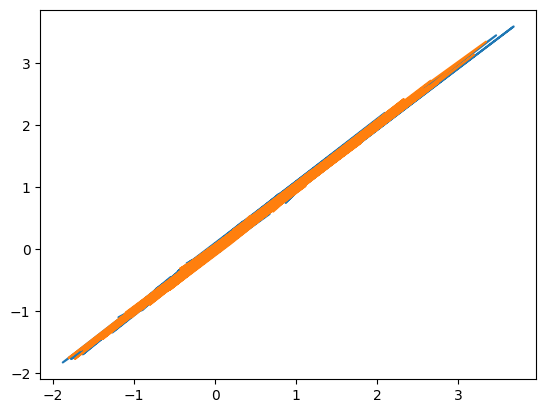

In [16]:
plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,0],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,0])

plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,1],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,1])

## STRAND
### Sender receiver model
#### STRAND simulation

In [11]:
import os
os.environ['R_HOME'] = 'C:/PROGRA~1/R/R-43~1.3/'
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [12]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Mass = rbern(N_id, 0.4)

#################################################### Simulate SBM + SRM network
sr_effects_1 = c(-1.9, 1.3)
G = simulate_srm_network(N_id = N_id, 
                         #B = B, 
                         #V=3,
                         #groups=groups,                  
                         sr_mu = c(0,0),  
                         sr_sigma = c(2.2, 1.7) , 
                         sr_rho = 0.55,
                         mode="poisson",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = NULL,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = NULL
                         )        

################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "poisson")

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ 1,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr only.Rdata')


'utf-8' codec can't decode byte 0xe9 in position 57: invalid continuation byte


Exception ignored from cffi callback <function _consolewrite_ex at 0x0000022B10DA11C0>:
Traceback (most recent call last):
  File "C:\Users\SSosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\SSosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 57: invalid continuation byte


RInterpreterError: Failed to parse and evaluate line '# Clear working space\nrm(list = ls())\nset.seed(10)\n# Load libraries\nlibrary(STRAND)\nlibrary(rethinking)\nlibrary(ggplot2)\n\n# Make data\nN_id = 50\n\n# Covariates\nMass = rbern(N_id, 0.4)\n\n#################################################### Simulate SBM + SRM network\nsr_effects_1 = c(-1.9, 1.3)\nG = simulate_srm_network(N_id = N_id, \n                         #B = B, \n                         #V=3,\n                         #groups=groups,                  \n                         sr_mu = c(0,0),  \n                         sr_sigma = c(2.2, 1.7) , \n                         sr_rho = 0.55,\n                         mode="poisson",                  \n                         individual_predictors = data.frame(Mass=Mass),\n                         dyadic_predictors = NULL,\n                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),\n                         dyadic_effects = NULL\n                         )        \n\n################################################### Organize for model fitting\nmodel_dat = make_strand_data(outcome=list(G$network),  \n                              individual_covariates=data.frame(Mass=Mass), \n                              outcome_mode = "poisson")\n\n# Model the data with STRAND\nfit =  fit_social_relations_model(data=model_dat,\n                              focal_regression = ~ Mass,\n                              target_regression = ~ Mass,\n                              dyad_regression = ~ 1,\n                              mode="mcmc",\n                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,\n                                                          refresh = 500,iter_warmup = 500,\n                                                          iter_sampling = 500,\n                                                          max_treedepth = NULL,\n                                                          adapt_delta = .9)\n                            )\n\n## Check parameter recovery\nres = summarize_strand_results(fit)\nsave(fit, model_dat, file = \'STRAND sim sr only.Rdata\')\n'.
R error message: "'utf-8' codec can't decode byte 0xe9 in position 57: invalid continuation byte"

#### Send simulation to python

In [1]:
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.3'
%load_ext rpy2.ipython

C:\Users\SSosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [ ]:
%%R
library(ggplot2)

In [ ]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr only.Rdata')
res = summarize_strand_results(fit)

In [ ]:
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
id = r.randint(1, data['N_id'][0]-1)


#### Model

In [69]:
ids = jnp.arange(0,data['N_id'][0])
idx = bi.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))
@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model(idx, result_outcomes,focal_individual_predictors, target_individual_predictors):
    N_id = ids.shape[0]

    ## Block ---------------------------------------
    B = bi.dist.normal(logit(0.1/jnp.sqrt(N_id)), 2.5, shape=(1,), name = 'block')

    #SR ---------------------------------------
    sr_terms, focal_effects, target_effects = bi.net.nodes_terms(focal_individual_predictors, target_individual_predictors)# shape = N_id
    sr_rf, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(N_id, cholesky_density = 2) # shape = N_id
    sender_receiver = sr_terms + sr_rf
    
    ### Dyadic--------------------------------------  
    dr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(idx.shape[0], cholesky_density = 2)# shape = n dyads

    ## SR ---------------------------------------                                                      
    lk('Y', Poisson(jnp.exp(B[0] + sender_receiver + dr)), obs=result_outcomes)  

    ## NBDA -----------------------------     

m.data_on_model = dict(
    idx = idx,
    result_outcomes = bi.net.mat_to_edgl(data['outcomes']), 
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors'],
)

m.run(model) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'block[0]',]]
# focal_effects = -1.9,
# target_effects =  1.3
# block =  -4

sample: 100%|██████████| 1000/1000 [00:23<00:00, 41.95it/s, 255 steps of size 2.31e-02. acc. prob=0.95]


BI took: 24.1209 seconds


,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],-1.53,0.57,-2.46,-0.68
target_effects[0],1.37,0.39,0.73,1.97
block[0],-3.97,0.54,-4.76,-3.05


In [70]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr only.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)


                               res.summary.Variable res.summary.Median
1                                  focal effects sd              1.931
2           focal effects coeffs (out-degree), Mass             -1.467
3                                 target effects sd              1.345
4           target effects coeffs (in-degree), Mass               1.45
5                                 dyadic effects sd              0.977
6 focal-target effects rho (generalized recipocity)              0.531
7            dyadic effects rho (dyadic recipocity)              0.783
8                             intercept, any to any             -3.933


### Sender receiver & dyadic effects model

In [71]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship
#dyadic_preds[,,2] = Dominant
#dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0  
dr_sigma = 1.5
dr_rho= 0.6

#################################################### Simulate SBM + SRM network
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2, 1.7, -2.2)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         #B = B, 
                         #V=3,
                         #groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         mode="poisson",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1                         
                         )        
################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "poisson", dyadic_covariates=list(Kinship=Kinship))

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr dyad.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 464.2 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.051" "1.814"   "2.239"  
[2,] "focal effects coeffs (out-degree), Mass" "1.88"  "1.364"   "2.27"   
     Mean    SD     
[1,] "2.034" "0.131"
[2,] "1.859" "0.295"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.906" "1.601"   "2.171"  
[2,] "target effects coeffs (in-degree), Mass" "0.536" "0.041"   "0.788"  
     Mean    SD     
[1,] "1.914" "0.174"
[2,] "0.48"  "0.236"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyad

Loading required package: cmdstanr
This is cmdstanr version 0.8.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.35.0
- CmdStan version: 2.35.0
Loading required package: posterior
This is posterior version 1.6.0

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpw5c4ik/model-91337dd

#### Send simulation to python

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dyad.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.051" "1.814"   "2.239"  
[2,] "focal effects coeffs (out-degree), Mass" "1.88"  "1.364"   "2.27"   
     Mean    SD     
[1,] "2.034" "0.131"
[2,] "1.859" "0.295"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.906" "1.601"   "2.171"  
[2,] "target effects coeffs (in-degree), Mass" "0.536" "0.041"   "0.788"  
     Mean    SD     
[1,] "1.914" "0.174"
[2,] "0.48"  "0.236"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "1.485" "1.448"   "1.526"   "1.487"
[2,] "dyadic effects coeffs, Kinship" "0.54"  "0.102"   "0.952"   "0.512"
     SD     
[1,] "0.025"
[2,] "0.257"

$`Other estimates`
     Variable                                            Median  

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [3]:
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'].reshape(data['N_id'][0],data['N_id'][0]).T
exposure = data['exposure'].reshape(data['N_id'][0],data['N_id'][0]).T

jax.local_device_count 32


#### Model

In [4]:
# Building model and sampling it ------------------
ids = jnp.arange(0,data['N_id'][0])
idx = bi.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))

@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model2(idx, result_outcomes, dyad_effects, focal_individual_predictors, target_individual_predictors):
    N_id = ids.shape[0]

    # Block ---------------------------------------
    B = bi.dist.normal(logit(0.1/jnp.sqrt(N_id)), 2.5, shape=(1,), name = 'block')

    ## SR ---------------------------------------
    sr_terms, focal_effects, target_effects = bi.net.nodes_terms(focal_individual_predictors, target_individual_predictors)# shape = N_id
    sr_rf, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(N_id, cholesky_density = 2) # shape = N_id
    sender_receiver = sr_terms + sr_rf

    # Dyadic--------------------------------------  
    dr_terms, dyad_effects = bi.net.dyadic_terms(dyad_effects)
    rf, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(sender_receiver.shape[0], cholesky_density = 2)
    dr = dr_terms + rf

    lk('Y', Poisson(jnp.exp(B[0] + sender_receiver + dr )), obs=result_outcomes)

m.data_on_model = dict(
    idx = idx,
    result_outcomes = bi.net.mat_to_edgl(data['outcomes']), 
    dyad_effects = bi.net.prepare_dyadic_effect(kinship), # Can be a jax array of multiple dimensions
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors']
)

m.run(model2) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]', 'block[0]']]
# focal_effects = 1.9,
# target_effects =  1.3
# dr_effects = 1.2, 1.7, -2.2
# block =  -4

In [18]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dyad.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)


                               res.summary.Variable res.summary.Median
1                                  focal effects sd              2.051
2           focal effects coeffs (out-degree), Mass               1.88
3                                 target effects sd              1.906
4           target effects coeffs (in-degree), Mass              0.536
5                                 dyadic effects sd              1.485
6                    dyadic effects coeffs, Kinship               0.54
7 focal-target effects rho (generalized recipocity)              0.656
8            dyadic effects rho (dyadic recipocity)              0.653
9                             intercept, any to any              0.472


### Sender receiver,  dyadic effects & block model
#### Simulation

In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
%%R
# Make data
set.seed(1)
library(base)
N_id = 10
V = 3
groups_1 = rep("Any",N_id)                                                                                  # Block Variable 1, Intercept
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=c(0.5, 0.25, 0.25) )           # Block Variable 2, Color
groups_3 = sample( c("Strangeness", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )                 # Block Variable 3, Flavor 

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Color=as.numeric(factor(groups_2)), Flavor=as.numeric(factor(groups_3)))

# Block parameter structure
B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(base::rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(base::rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B = list(B_1, B_2, B_3)

# Build offset matrix
block_offsets = matrix(NA, N_id, N_id)

# Loop over upper triangle and create ties from i to j, and j to i
for ( i in 1:(N_id-1) ){
    for ( j in (i+1):N_id){

 # Loop over block variables
   B_i_j = B_j_i = c()
  for(v in 1:V){
    B_i_j[v] =  B[[v]][groups[i,v] , groups[j,v] ]
    B_j_i[v] =  B[[v]][groups[j,v] , groups[i,v] ]
  }

 block_offsets[i,j] =  sum(B_i_j)
 block_offsets[j,i] =  sum(B_j_i)

 }}

# Now reshape into N_dydads X 2 matrix
melted = cbind(block_offsets[lower.tri(block_offsets,diag=FALSE)],
               block_offsets[upper.tri(block_offsets,diag=FALSE)])

block_offsets
melted

# quick check is the same both column 1 and column 2 becuase ind_1 and ind_2 are in the same block for both color and flavor
melted[1,]
groups[1:2,]


Error in matrix(base::rnorm(9, 0, 3), nrow = 3, ncol = 3) : 
  object 'rnorm' not found


RInterpreterError: Failed to parse and evaluate line '# Make data\nset.seed(1)\nlibrary(base)\nN_id = 10\nV = 3\ngroups_1 = rep("Any",N_id)                                                                                  # Block Variable 1, Intercept\ngroups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=c(0.5, 0.25, 0.25) )           # Block Variable 2, Color\ngroups_3 = sample( c("Strangeness", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )                 # Block Variable 3, Flavor \n\ngroups = data.frame(Intercept=as.numeric(factor(groups_1)), Color=as.numeric(factor(groups_2)), Flavor=as.numeric(factor(groups_3)))\n\n# Block parameter structure\nB_1 = matrix(-10,nrow=1,ncol=1)\nB_2 = matrix(base::rnorm(9,0,3),nrow=3,ncol=3)\nB_3 = matrix(base::rnorm(4,0,3),nrow=2,ncol=2)\n\ndiag(B_2) = diag(B_2) + 2\ndiag(B_3) = diag(B_3) + 3.5\n\nB = list(B_1, B_2, B_3)\n\n# Build offset matrix\nblock_offsets = matrix(NA, N_id, N_id)\n\n# Loop over upper triangle and create ties from i to j, and j to i\nfor ( i in 1:(N_id-1) ){\n    for ( j in (i+1):N_id){\n\n # Loop over block variables\n   B_i_j = B_j_i = c()\n  for(v in 1:V){\n    B_i_j[v] =  B[[v]][groups[i,v] , groups[j,v] ]\n    B_j_i[v] =  B[[v]][groups[j,v] , groups[i,v] ]\n  }\n\n block_offsets[i,j] =  sum(B_i_j)\n block_offsets[j,i] =  sum(B_j_i)\n\n }}\n\n# Now reshape into N_dydads X 2 matrix\nmelted = cbind(block_offsets[lower.tri(block_offsets,diag=FALSE)],\n               block_offsets[upper.tri(block_offsets,diag=FALSE)])\n\nblock_offsets\nmelted\n\n# quick check is the same both column 1 and column 2 becuase ind_1 and ind_2 are in the same block for both color and flavor\nmelted[1,]\ngroups[1:2,]\n'.
R error message: "Error in matrix(base::rnorm(9, 0, 3), nrow = 3, ncol = 3) : \n  object 'rnorm' not found"

In [3]:
%%R 
#####################################
#
#   Binomial Analyses - Simulated data  
#
########################################

# Clear working space
rm(list = ls())
set.seed(1)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)


# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.6
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2, 1.7, -2.2)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))

#################################################### Simulate SBM + SRM network
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=3,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         mode="binomial",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1
                         )        

################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  block_covariates=groups_f, individual_covariates=data.frame(Mass=Mass), 
                           dyadic_covariates=list(Kinship=Kinship, Dominant=Dominant),  outcome_mode = "binomial", exposure=list(G$samps))

# Model the data with STRAND
fit =  fit_block_plus_social_relations_model(data=model_dat,
                            block_regression = ~ Merica + Quantum,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1, refresh = 500,
                                                          iter_warmup = 500, iter_sampling = 500,
                                                          max_treedepth = NULL, adapt_delta = .9)
)

# Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr dr block.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 195.6 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.608" "2.215"   "3.084"  
[2,] "focal effects coeffs (out-degree), Mass" "1.005" "0.041"   "2"      
     Mean    SD     
[1,] "2.643" "0.28" 
[2,] "1.017" "0.606"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.854" "1.544"   "2.226"  
[2,] "target effects coeffs (in-degree), Mass" "0.876" "0.049"   "1.648"  
     Mean    SD     
[1,] "1.884" "0.222"
[2,] "0.881" "0.483"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyad

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpVGXQWk/model-cc05a275f9d.stan', line 132, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpVGXQWk/model-cc05a275f9d.stan', line 132, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the s

#### Send simulation to python

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dr block.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.608" "2.215"   "3.084"  
[2,] "focal effects coeffs (out-degree), Mass" "1.005" "0.041"   "2"      
     Mean    SD     
[1,] "2.643" "0.28" 
[2,] "1.017" "0.606"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.854" "1.544"   "2.226"  
[2,] "target effects coeffs (in-degree), Mass" "0.876" "0.049"   "1.648"  
     Mean    SD     
[1,] "1.884" "0.222"
[2,] "0.881" "0.483"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "1.528" "1.429"   "1.626"   "1.529"
[2,] "dyadic effects coeffs, Kinship" "0.781" "0.075"   "1.523"   "0.781"
     SD     
[1,] "0.062"
[2,] "0.448"

$`Other estimates`
      Variable                                            Median 

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [3]:
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'][0,:,:].reshape(data['N_id'][0],data['N_id'][0]).T
Any = data['block_predictors'][0,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Merica  = data['block_predictors'][1,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Quantum  = data['block_predictors'][2,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1

jax.local_device_count 32


#### Model

In [8]:
Merica

Array([1., 1., 3., 3., 3., 1., 1., 3., 1., 2., 3., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 3., 1., 3., 2., 1., 3., 3., 3., 1., 2., 3., 3., 3.,
       3., 3., 2., 2., 1., 3., 3., 3., 1., 1., 3., 2., 3., 2., 1., 2.],      dtype=float32)

In [17]:
b, b_ij, b_ii = bi.net.block_model_prior(3, sample = True)
print(b)
edgl_block = Net.block_prior_to_edglelist(Merica-1, b)
jnp.sum(edgl_block, axis = 1)

[ 1.747793  -4.488108  -5.6050053]


Array([ 3.495586 , -3.8572123, -3.8572123, ..., -2.7403152, -8.976216 ,
       -2.7403152], dtype=float32)

In [20]:
# Building model and sampling it ------------------
ids = jnp.arange(0,data['N_id'][0])
idx = bi.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))

@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model3(idx, result_outcomes, kinship, focal_individual_predictors, target_individual_predictors, Any, Merica, Quantum):
    N_id = ids.shape[0]

    # Block ---------------------------------------
    B_any, b_any, b_ij_any, b_ii_any = bi.net.block_model(Any,1, name_b_ij = 'b_ij_Any', name_b_ii = 'b_ii_Any' )
    B_Merica, b_Merica, b_ij_Merica, b_ii_Merica = bi.net.block_model(Merica,  3, name_b_ij = 'b_ij_Merica', name_b_ii = 'b_ii_Merica' )
    B_Quantum, b_Quantum, b_ij_Quantum, b_ii_Quantum = bi.net.block_model(Quantum, 2, name_b_ij = 'b_ij_Quantum', name_b_ii = 'b_ii_Quantum' )

    jnp
    ## SR ---------------------------------------
    sr_terms, focal_effects, target_effects = bi.net.nodes_terms(focal_individual_predictors, target_individual_predictors)
    sr_rf, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(sr_terms.shape[0], cholesky_density = 2)

    sender = sr_terms[idx[:,0],0] + sr_terms[idx[:,1],1] + sr_rf[idx[:,0],0]
    receiver =  sr_terms[idx[:,1],0] + sr_terms[idx[:,0],1] + sr_rf[idx[:,1],1]
    sender_receiver = jnp.stack([sender, receiver], axis = 1)

    # Dyadic--------------------------------------  
    dr_terms, dyad_effects = bi.net.dyadic_terms(kinship[:,0], kinship[:,1])
    rf, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(idx.shape[0], cholesky_density = 2)
    dr = dr_terms + rf

    lk('Y', Poisson(jnp.exp(B_any + B_Merica + B_Quantum + sender_receiver + dr )), obs=result_outcomes)

m.data_on_model = dict(
    idx = idx,
    Any = Any-1, 
    Merica = Merica-1, 
    Quantum = Quantum-1,
    result_outcomes = bi.net.mat_to_edgl(data['outcomes']), 
    kinship = bi.net.mat_to_edgl(kinship),
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors']
)

m.run(model3) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]']]
# focal_effects = 1.9,
# target_effects =  1.3
# dr_effects = 1.2, 1.7, -2.2


sample: 100%|██████████| 1000/1000 [01:31<00:00, 10.87it/s, 1023 steps of size 2.36e-04. acc. prob=0.84]


BI took: 92.3467 seconds


,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],0.18,0.01,0.17,0.21
target_effects[0],0.42,0.01,0.41,0.44
dyad_effects[0],0.35,0.03,0.32,0.39


In [21]:
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]',
 'b_ii_Any[0]',
'b_ii_Merica[0]',
'b_ii_Merica[1]',
'b_ii_Merica[2]',
'b_ij_Merica[0, 0]',
'b_ij_Merica[0, 1]',
'b_ij_Merica[0, 2]',
'b_ij_Merica[1, 0]',
'b_ij_Merica[1, 1]',
'b_ij_Merica[1, 2]',
'b_ij_Merica[2, 0]',
'b_ij_Merica[2, 1]',
'b_ij_Merica[2, 2]',

'b_ij_Quantum[0, 0]',
'b_ij_Quantum[0, 1]',
'b_ij_Quantum[1, 0]',
'b_ij_Quantum[1, 1]',
'b_ii_Quantum[0]',
'b_ii_Quantum[1]'
]]

,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],0.18,0.01,0.17,0.21
target_effects[0],0.42,0.01,0.41,0.44
dyad_effects[0],0.35,0.03,0.32,0.39
b_ii_Any[0],0.54,0.02,0.51,0.56
b_ii_Merica[0],-0.20,0.01,-0.22,-0.18
b_ii_Merica[1],-2.33,0.11,-2.47,-2.14
b_ii_Merica[2],-2.74,0.06,-2.89,-2.67
"b_ij_Merica[0, 0]",-2.66,0.02,-2.68,-2.63
"b_ij_Merica[0, 1]",-0.54,0.02,-0.57,-0.51
"b_ij_Merica[0, 2]",-0.25,0.02,-0.28,-0.21


In [20]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dyad.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)

                                res.summary.Variable res.summary.Median
1                                   focal effects sd              2.608
2            focal effects coeffs (out-degree), Mass              1.005
3                                  target effects sd              1.854
4            target effects coeffs (in-degree), Mass              0.876
5                                  dyadic effects sd              1.528
6                     dyadic effects coeffs, Kinship              0.781
7  focal-target effects rho (generalized recipocity)              0.557
8             dyadic effects rho (dyadic recipocity)              0.459
9                                 offset, Any to Any              1.934
10                              offset, Blue to Blue             -1.439
11                               offset, Blue to Red             -5.524
12                             offset, Blue to White             -0.867
13                               offset, Red to Blue            

## BISONR

In [3]:
df = pd.read_csv('bison sim data.csv')
df.shape

(45, 7)

### Binary

In [4]:
num_rows = df.shape[0] 
N_id = len(jnp.unique(jnp.stack([jnp.array(df.node_1_id.values), jnp.array(df.node_2_id.values)]).flatten()))
N_dyads = jnp.arange(0,(N_id*(N_id-1))/2)
num_edges = len(N_dyads)

num_fixed = 0 # Number of fixed effect parameters
num_random = 0 # Number of random effect parameters
num_random_groups = 0 # Number of random effect groups

event = jnp.array(df.event.values) # Outcome for each data point (presence/absence)
divisor = jnp.array(df.duration.values) # Duration of each observation
dyad_ids = jnp.arange(0,(N_id*(N_id-1))/2, dtype= jnp.int32)  # Dyad IDs of each observation for indexing edge weights

design_fixed = 0 # Design matrix for fixed effects
design_random = 0 # Design matrix for random effects.
random_group_index = 0 # Index for groupings for random effects


prior_edge_mu = 0 #  Prior mean for fixed effects
prior_edge_sigma  =  2.5 #  Prior standard deviation for fixed effects
prior_fixed_mu  = 0 #  Prior mean for fixed effects
prior_fixed_sigma  = 2.5 #  Prior standard deviation for fixed effects
prior_random_mean_mu  = 0 #  Prior mean on centralisation of random effects
prior_random_mean_sigma  = 1 #  Prior standard deviation on centralisation of random effects
prior_random_std_sigma  = 1 #  Prior standard deviation on dispersion of random effects
prior_zero_prob_alpha  = 1 #  Prior alpha on zero inflation
prior_zero_prob_beta  = 1 #  Prior beta on zero inflation
priors_only  = 0 # Whether to sample from only the priors
partial_pooling  = 0 # Whether to pool edge weight estimates
zero_inflated  = False # Whether to use zero-inflated edge model

edge_weight = jnp.zeros((num_edges,)) # Parameters for edge weights.
beta_fixed = jnp.zeros((num_fixed,)) # Parameters for fixed effects.
beta_random = jnp.zeros((num_random,)) # Parameters for random effects.
random_group_mu = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (mean).
random_group_sigma = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (std. dev.).
edge_sigma = jnp.zeros((partial_pooling,)) # Random effect for edge weight pooling.
#zero_prob = jnp.zeros((zero_inflated,)) # Zero inflated parameter for probability of zeroes.
if zero_inflated:
    zero_prob = 0
else :
    zero_prob = 0.5

In [5]:
predictor = jnp.ones((num_rows,)) + edge_weight[dyad_ids] + jnp.repeat(0, num_rows) + jnp.repeat(0, num_rows) 
#design_fixed * beta_fixed
#design_random * beta_random

In [9]:
zero_prob = numpyro.distributions.Beta(1.0, 1.0)
predictor = jnp.ones(event.shape)
prob = jax.nn.sigmoid(predictor)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Binomial(total_count=divisor, probs=prob), 
    gate=0.51848227
), obs=event)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Poisson(rate=event/divisor), 
    gate=0.51848227
), obs=event)


Array([3, 0, 3, 4, 2, 3, 1, 5, 3, 0, 2, 3, 3, 1, 0, 0, 0, 2, 1, 2, 1, 3,
       5, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 5, 3,
       1], dtype=int32)

In [ ]:
import jax.scipy as jsp
if zero_inflated:
    event = bi.dist.binomial(divisor, jax.nn.sigmoid(predictor))
else:
    inv_logit_predictor = jax.nn.sigmoid(predictor)
    log_binomial = jsp.stats.binom.logpmf(event, divisor, inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_binomial
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_binomial])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Count

In [ ]:
import jax.scipy as jsp

if zero_inflated == 0:
    event = bi.dist.poisson(jnp.exp(predictor) * divisor)
else:
    exp_predictor = jnp.exp(predictor)
    log_poisson = jsp.stats.poisson.logpmf(event, divisor, exp_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_poisson
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_poisson])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Duration

In [ ]:
import jax.scipy as jsp
edge_weight_cov = bi.lkjcholesky(2,2, sample = True)
event_count = jnp.array((num_edges,))  # Outcome for each data point (presence/absence)
dyad_ids_receiver = jnp.array((num_rows,))   # Dyad ID for receiver if using sender/receiver effects
prior_rate_sigma = 1 #Prior on standard deviation of event rate
sender_receiver = 1 #Whether to use sender-receiver effects
rate = jnp.array((num_edges,))
sender_receiver_cov = jnp.array((sender_receiver,))
inv_logit_predictor = jax.nn.sigmoid(predictor)

if zero_inflated == 0:
    event = bi.dist.exponential(rate[dyad_ids] / inv_logit_predictor)
    event_count = bi.dist.poisson(rate * divisor)

else:
    exp_predictor = jnp.exp(predictor)    
    log_exponential = jsp.stats.expon.logpmf(event, rate[dyad_ids], inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_exponential
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_exponential])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    rate = bi.dist.normal(0, prior_rate_sigma, sample = True)
    if partial_pooling == 0:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #}
        else:
            edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma)
    else:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #} 
        else:       
            edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
    
    edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

## NBDA

## Multiplexe

# Dirichlet Multinomial with centered random factors

In [103]:
import seaborn as sns
import numpy as np
from jax import random
from jax.nn import softmax
import jax.numpy as jnp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

###############################################################################
############ SIMULATING MULTINOMIAL DATA WITH SOFTMAX LINK FUNCTION ###########
def mysoftmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=0)

K = 3
N = 100
N_obs = 2
sigma_random = 0.6


########################################################
################### Fixed effect Sim ###################
#a = np.random.normal(0, 1, K)
a = np.array([3,1,1]) # Forcing a values


# Factors--------------------------
NY = 4
NV = 8

Y2 = np.full((NV, NY), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[i,k] = means[k] + offsets[i]

    
b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a


# Declare an empty Matrix to fill with data
Y = np.empty((N * N_obs, K))

# Declare an empty vector to fill with IDs
id = []

# Loop over each individual
for i in range(N):
    # Simulate N_obs draws from the multinomial
    Y[i*N_obs:(i+1)*N_obs, :] = np.apply_along_axis(lambda x: np.random.multinomial(100, mysoftmax(x)), 0, mu[i])
    # Assign ID vector
    id += [i] * N_obs


N = N*N_obs
K = K
ni = N
y = jnp.array(Y, dtype=jnp.int32).reshape(N, K)
i_ID = jnp.array(id)

dat = dict(
    K = K,
    ni = ni,
    y = y,
    i_ID = i_ID
)

## Latent variable model

In [104]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_key = jnp.array(init_key)
init_key

Array([4146024105,  967050713], dtype=uint32)

In [105]:
import pandas as pd 
import math
import os
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro

import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("cpu")
numpyro.set_host_device_count(30)


# Simulation ---------------
NY = 4
NV = 8

Y2 = np.full((NV, NY), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[i,k] = means[k] + offsets[i]

b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a

Y2 = jnp.array(Y2)



In [106]:

# Building model and sampling it ------------------
def model(NY, NV, Y2):
    means =  numpyro.sample('means', numpyro.distributions.Normal(0,1).expand([NY]))
    offset =  numpyro.sample('offset', numpyro.distributions.Normal(0,1).expand([NV,1]))
    sigma =  numpyro.sample('sigma', numpyro.distributions.Exponential(1).expand([NY])) 
    tmp = jnp.tile(means, (NV, 1)).reshape(NV,NY)  
    mu_l = tmp + offset 
    numpyro.sample('Y2', numpyro.distributions.Normal(mu_l, jnp.tile(sigma, [NV, 1])), obs=Y2)

dat = dict(
    NY = NY,
    NV = NV,
    Y2 = Y2
)
m = MCMC(NUTS(model, init_strategy = numpyro.infer.init_to_median()), num_warmup=1000, num_samples=1000, num_chains=1)
m.run(random.PRNGKey(0), extra_fields=["diverging"], **dat)

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1386.84it/s, 1023 steps of size 1.50e-07. acc. prob=0.79]


In [31]:
import arviz as az
data = az.from_numpyro(m)
az.summary(data)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],0.519,0.0,0.519,0.519,0.0,0.0,1000.0,1000.0,NaN
means[1],0.191,0.0,0.191,0.191,0.0,0.0,1000.0,1000.0,NaN
means[2],0.657,0.0,0.657,0.657,0.0,0.0,1000.0,1000.0,NaN
means[3],-0.613,0.0,-0.613,-0.613,0.0,0.0,1000.0,1000.0,NaN
"offset[0, 0]",0.530,0.0,0.530,0.530,0.0,0.0,1000.0,1000.0,NaN
"offset[1, 0]",0.812,0.0,0.812,0.812,0.0,0.0,1000.0,1000.0,NaN
"offset[2, 0]",-0.366,0.0,-0.366,-0.366,0.0,0.0,1000.0,1000.0,NaN
"offset[3, 0]",2.077,0.0,2.077,2.077,0.0,0.0,1000.0,1000.0,NaN
"offset[4, 0]",0.988,0.0,0.988,0.988,0.0,0.0,1000.0,1000.0,NaN
"offset[5, 0]",0.342,0.0,0.342,0.342,0.0,0.0,1000.0,1000.0,NaN


In [32]:
means

array([1.28912305, 0.96183663, 1.42779941, 0.15728591])

## Random centered effects

In [107]:
@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors 

    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k

    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)

In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = random_centered(Sigma_individual, L_individual, z_individual)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1)


In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:
[0.7328625  0.13674371 0.13039377]


In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = random_centered2(Sigma_individual, L_individual, z_individual)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1)

In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:
[0.66280484 0.1774538  0.15974137]


In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    print(L_individual.shape)
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = ((Sigma_individual[..., None] * L_individual) @ z_individual)
    print(alpha.shape)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1, chain_method='vectorized')

In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:


AttributeError: 'bi' object has no attribute 'trace'

In [ ]:
###############################################################################
#################################### Pustan Model  #############################
import time as tm
import stan
import nest_asyncio
import numpy as np
tmp = dat
tmp['y'] = np.array(tmp['y'])
tmp['i_ID'] = np.array(tmp['i_ID']+1)
tmp['ni'] = tmp['ni']
tmp['K'] = tmp['K']
tmp['N'] = int(N)

nest_asyncio.apply()
stan_code = """ 
data {
    int<lower=0>  N;             // number of observations
    int<lower=0>  K;             // number of occupations
    int ni;                     // NUmber of Unique Individauls
    array[N, K] int y;           // array of observed occupation indicators
    array[N]int<lower=0>  i_ID;     // village indicator for each individual
}
parameters {
    vector[K] a;                    // intercept for each occupation
    matrix[ni, K]  z_individual;    // raw random effect for household 
    cholesky_factor_corr[ni] L_individual; // Cholesky factor for 
    vector<lower=0>[ni] Sigma_individual;

}
transformed parameters{
    matrix[ni, K] b_individual;
    b_individual = diag_pre_multiply(Sigma_individual, L_individual) * z_individual;
}
model{
    array[N] vector[K] p;
    matrix[N, K] random_effects;
    to_vector(a) ~ normal(0, 1);
    L_individual ~   lkj_corr_cholesky(2);
    Sigma_individual ~ exponential(1);
    to_vector(z_individual) ~ normal(0, 1);
    // Likelihood for
    for (k in 1:K) {
        for (i in 1:N) {
          random_effects[i, k] = b_individual[i_ID[i], k];
          p[i,k] =  a[k] + random_effects[i, k];
      }
    }
    for (i in 1:(N)) {
        y[i,] ~ dirichlet_multinomial(exp(p[i,]));
    }
}
"""

start = tm.time()
stan_model = stan.build(stan_code, data = tmp)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500, init = [{'L_individual': np.zeros((tmp['ni'], tmp['ni']))}])
end = tm.time()    
#df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Sampling:   0%/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Sampling:   0% (1/1000)
Sampling:  10% (100/1000)
Sampling:  20% (200/1000)
Sampling:  30% (300/1000)
Sampling:  40% (400/1000)
Sampling:  50% (500/1000)
Sampling:  50% (501/1000)
Sampling:  60% (600/1000)
Sampling:  70% (700/1000)
Sampling:  80% (800/1000)
Sampling:  90% (900/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 0.006054 seconds
  1000 transitions using 10 leapfrog steps per transition would take 60.54 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_cholesky_lpdf: Random variable[6] is 0

Pystan took: 432.2593 seconds


In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(np.array([3,1,1])))) 
print('Estimation Multinomial:')
post = m.sampler.get_samples()
print(jax.nn.softmax(jnp.mean(post['a'], axis = 0)))
print('Estimation DirichletMultinomial:')
#post = m2.sampler.get_samples()
#print(jax.nn.softmax(jnp.mean(post['a'], axis = 0)))
df = fit.to_frame()
print('Pytstan estimation')
print(jax.nn.softmax(jnp.array([df['a.1'].mean(),df['a.2'].mean(),df['a.3'].mean()])))

Simulated:
[0.786986   0.10650697 0.10650697]
Estimation Multinomial:
[0.79368174 0.11202765 0.0942907 ]
Estimation DirichletMultinomial:
Pytstan estimation
[0.7914235  0.11247264 0.09610377]


## Gaussian process

In [2]:
from Mutils import Mgaussian, cov_GPL2
from jax.scipy.stats import norm
gaus = Mgaussian()

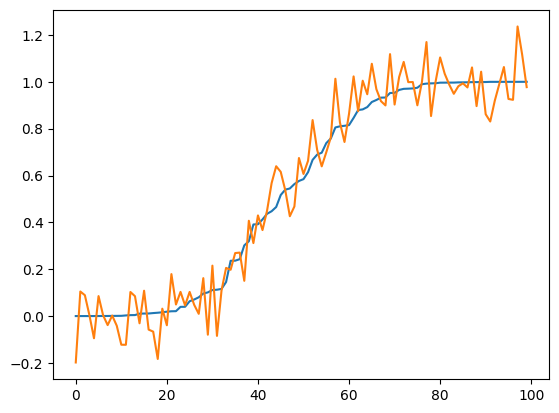

In [3]:
raw = sample.uniform(-4,4, sample_shape=(100,))
raw  = jnp.sort(raw)
sequence = jnp.array([i for i in range(1, 11) for _ in range(10)])
unique = jnp.unique(jnp.array(sequence))
result = []

for i in range(0,len(unique)):  
    result.append(jnp.mean(raw[jnp.where(sequence==(i + 1))], axis = 0))

Dmat = gaus.distance_matrix(jnp.array(result))
cdf_value = norm.cdf(raw , loc=0, scale=1)# to plot for after
plt.plot(jnp.arange(0, 100), cdf_value)
error = sample.normal(0, 0.1, sample_shape=(100,))
y = cdf_value + error
plt.plot(jnp.arange(0, 100), y)

In [7]:
def gaussian_process(Dmat, etasq, rhosq, sigmaq):
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, sigmaq)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = sample.normal(0, 1, sample_shape= (10,))
    k = numpyro.deterministic("k", (L_SIGMA @ z[..., None])[..., 0])
    return k

In [9]:
# Perform gaussain process through array of Nx3
a = sample.normal(0,1, (8, 20))
sigma = sample.exponential(1, sample_shape=(8*20,))
etasq = sample.exponential(2, sample_shape=(8*20,))
rhosq = sample.exponential(0.5, sample_shape=(8*20,))
sigmaq = sample.exponential(2, sample_shape= (8*20,))
tmp = jnp.stack([etasq, rhosq, sigmaq], axis = 1)
t = vmap(lambda x: gaussian_process(Dmat, x[0], x[1], x[2]))(tmp) # need to return 8 * 20 * 10
t.shape

(160, 10)

In [188]:
def gaus_model(Dmat, y ,sequence):
    a = dist.normal('a', 0,1)
    sigma = dist.exponential('s', 1)
    etasq = dist.exponential("etasq",2)
    rhosq = dist.exponential("rhosq",0.5)
    sigmaq = dist.exponential("sigmaq",2)

    SIGMA = cov_GPL2(Dmat, etasq, rhosq, sigmaq)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = dist.normal('z', 0, 1, sample_shape= [10])
    k = numpyro.deterministic("k", (L_SIGMA @ z[..., None])[..., 0])
    
    mu = a + k[sequence]

    lk('Y', Normal(mu, sigma), obs=y)

dat = dict(
    Dmat = Dmat,
    y = y,
    sequence = sequence - 1 
)

m = MCMC(NUTS(gaus_model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)


sample: 100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s, 191 steps of size 2.40e-02. acc. prob=0.92]


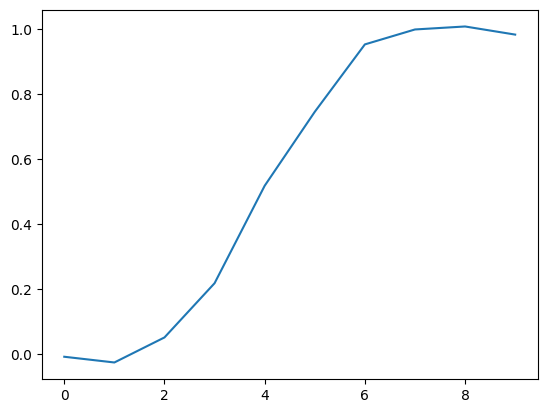

In [192]:
plt.plot(jnp.arange(0,10), jnp.mean(jnp.array(res['posterior']['a'])) + jnp.mean(jnp.array(res['posterior']['k'][0,:,:]), axis = 0))

## Combine latent, random and gaussian

In [485]:
# latent + random = random + latent[village[i]] with village being village ID
# gaussian simulation 
# 1. non linear function to generate gaussian proces for each parameters
# model 2 = random + latent[village[i]] + gaussian_process
# model 3  = model 2 + interaction effect
#interaction effect = non linear function where input is hhmembers[i]*offsets[vilage[i]] with new coefficients params
# Within model we need to change offset ouput as an integer so we do bxi*hhmembers[i]*offset[v_ID[i]]+ bxIsq*(hhmembers[i]*offset[v_ID[i]])


# Model on real data

In [486]:
def model(K, ni, y, i_ID):
    #individual 
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 50)
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha_individual = random_centered2(Sigma_individual, L_individual, z_individual)

    #household 
    Sigma_household = exponential('Sigma_household', [ni], 1 )
    L_household = lkjcholesky('L_household', [], ni, 50)
    z_household = normal('z_household', [ni,K], 0, 1)
    alpha_household = random_centered2(Sigma_household, L_household, z_household)

    #village 
    Sigma_village = exponential('Sigma_village', [ni], 1 )
    L_village = lkjcholesky('L_village', [], ni, 50)
    z_village = normal('z_village', [ni,K], 0, 1)
    alpha_village = random_centered2(Sigma_village, L_village, z_village)

    #LK
    random_factors = alpha_individual[i_ID] + alpha_household[i_ID] + alpha_village[i_ID]
    numpyro.sample("y", dist.DirichletMultinomial(a + random_factors[i_ID], int(12083)), obs=y)

# Model to latex

In [69]:
import re
from IPython.display import display, Latex
greek_symbols = {
    'alpha': '\\alpha',
    'beta': '\\beta',
    'gamma': '\\gamma',
    'delta': '\\delta',
    'epsilon': '\\epsilon',
    'zeta': '\\zeta',
    'eta': '\\eta',
    'theta': '\\theta',
    'iota': '\\iota',
    'kappa': '\\kappa',
    'lambda': '\\lambda',
    'mu': '\\mu',
    'nu': '\\nu',
    'xi': '\\xi',
    'omicron': 'o',  # No direct LaTeX symbol for omicron, using "o"
    'pi': '\\pi',
    'rho': '\\rho',
    'sigma': '\\sigma',
    'tau': '\\tau',
    'upsilon': '\\upsilon',
    'phi': '\\phi',
    'chi': '\\chi',
    'psi': '\\psi',
    'omega': '\\omega'
}

def convert_to_greek(var_name):
    # Convert variable name to lowercase for case-insensitive matching
    var_name_lower = var_name.lower()
    # Check if the variable name has a corresponding Greek symbol
    if var_name_lower in greek_symbols:
        return greek_symbols[var_name_lower]
    else:
        return var_name

def extract_latex(command):
    # Define a regular expression pattern to match the desired parts of the command
    pattern = r"(\w+)\s*=\s*(\w+)\([^,]+,\s*[^,]+,\s*(.*)\)"
    match = re.match(pattern, command)
    
    if match:
        var_name = match.group(1)
        func_name = match.group(2)
        params = match.group(3)
        # Convert var_name to Greek symbol if applicable
        var_name_latex = convert_to_greek(var_name)
        # Construct the desired LaTeX text
        latex_text = f"{var_name_latex} = {func_name}({params})"
        return latex_text
    else:
        return None

# Example usage
command = "Sigma_i = exponential('Sigma_individual', [ni], 1)"
latex_text = extract_latex(command)
display(Latex(f'''${latex_text}$'''))

<IPython.core.display.Latex object>

# Multiplex representation

## Network building

NameError: name 'control_point' is not defined

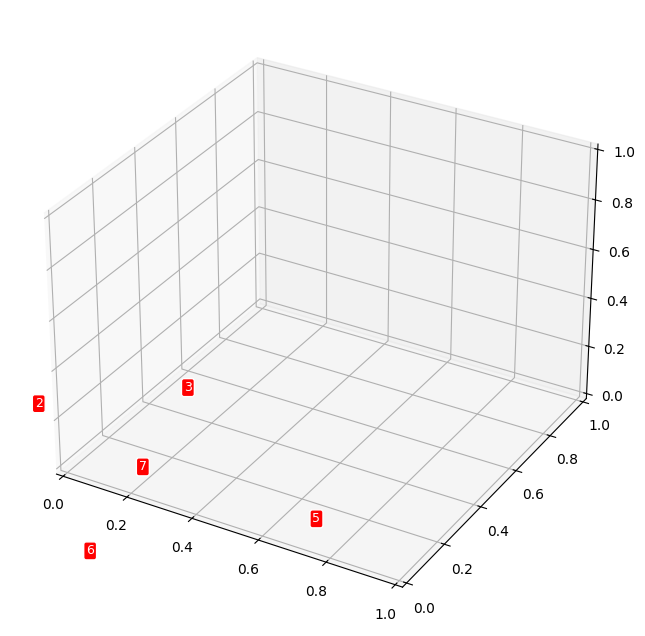

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Function to plot a quadratic Bezier curve (slight curve) with an arrow at the end
# Function to plot a quadratic Bezier curve (slight curve) with a scaled arrow at the end
def plot_curve_with_arrow(ax, p0, p1, p2, z_layer, link_color, show_arrow=False, arrow_scale=0.1, arrow_color = 'black'):
    t_vals = np.linspace(0, 1, 100)  # Parameter t values for interpolation
    curve_x = (1 - t_vals) ** 2 * p0[0] + 2 * (1 - t_vals) * t_vals * p1[0] + t_vals ** 2 * p2[0]
    curve_y = (1 - t_vals) ** 2 * p0[1] + 2 * (1 - t_vals) * t_vals * p1[1] + t_vals ** 2 * p2[1]
    curve_z = np.full_like(curve_x, z_layer)  # Keep z constant
    ax.plot(curve_x, curve_y, curve_z, color=link_color, alpha=0.8)

    if show_arrow:  # Add arrow to the last part of the curve
        # Define start and end points for the arrow
        arrow_start = np.array([curve_x[-2], curve_y[-2], curve_z[-2]])
        arrow_end = np.array([curve_x[-1], curve_y[-1], curve_z[-1]])
        
        # Ensure the arrow points in the correct direction
        direction = arrow_end - arrow_start
        if np.linalg.norm(direction) == 0:
            return  # Prevent division by zero if direction is zero

        direction = direction / np.linalg.norm(direction) * arrow_scale  # Scale the direction
        
        # Reverse the direction if needed (ensure the arrow points from p1 to p2)
        if (p2[0] < p1[0]) or (p2[1] < p1[1]):
            direction = -direction
        
        # Draw the arrow
        ax.quiver(arrow_start[0], arrow_start[1], arrow_start[2], 
                  direction[0], direction[1], direction[2], 
                  color=arrow_color, alpha=0.8, arrow_length_ratio=0.3)

# Updated plot_graph function to add node labels and arrows
def plot_graph(G, pos, color='blue', size=100, 
edgecolor='k', alpha=1, curvature=0.1, z=0, ax=None, 
nodes_color=None, nodes_shape=None,  
show_labels=False, labels = None, labels_color = 'white',
show_arrows=False,  arrow_scale=0.1, arrow_color = 'black'):

    if nodes_color is None:
        nodes_color = [color] * len(G.nodes())

    if nodes_shape is None:
        nodes_shape = ['o'] * len(G.nodes())

    if labels is None:
        labels = {node: str(node) for node in G.nodes()}  # Default label is the node number
    

    # Plot nodes

    for i, node in enumerate(G.nodes()):
        x, y = pos[node]       
        
        # Optionally show node labels
        if show_labels:
            # Add the label next to the node
            ax.text(x, y, z, labels[node], color=labels_color, fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor=color, edgecolor=labels_color, boxstyle='round,pad=0.2'))
        else:
            ax.scatter(x, y, z, color=nodes_color[i], marker=nodes_shape[i], s=size, edgecolor=edgecolor, alpha=alpha, zorder=2)


    # Plot edges with optional arrows
    for edge in G.edges():
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        p1 = np.array([x1, y1])
        p2 = np.array([x2, y2])
        control = control_point(p1, p2, curvature)  # Compute control point for curvature
        plot_curve_with_arrow(ax, p1, control, p2, z, color, show_arrow=show_arrows,  arrow_scale=arrow_scale, arrow_color = arrow_color)  # Draw curved edge with arrows



# Modify the multiplex plot function to accept show_arrows and show_labels arguments
def plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color=None, nodes_shape=None, 
intralayer_links_curvature=0.3, show_arrows=False, show_labels=False, labels = None,
arrow_scale  = 0.1, arrow_color = 'black'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(G)):
        plot_graph(G[i], layout, layers_colors[i], curvature=intralayer_links_curvature, z=layers_z_axis[i], 
                   nodes_color=nodes_color, nodes_shape=nodes_shape, ax=ax, show_arrows=show_arrows, 
                   show_labels=show_labels, arrow_scale=arrow_scale, arrow_color = arrow_color)
        
    inter_layer_links(G, layout, layers_z_axis, ax=ax)
    
    # Remove background, axis, and grid
    ax.set_axis_off()  # Turn off the axes
    ax.grid(False)  # Turn off the grid

    # Set viewing angle and plot
    ax.view_init(elev=20., azim=-60)  # Adjust view angle if needed
    plt.show()

# Example usage
# Parameters: n = number of nodes, k = each node is connected to k nearest neighbors in ring topology, p = rewiring probability
n = 10  # Number of nodes
k1, k2, k3 = 4, 3, 6  # Each node is connected to different neighbors in different layers
p1, p2, p3 = 0.3, 0.6, 0.2  # Rewiring probabilities
# Generate Watts-Strogatz graphs for each layer
G1 = nx.watts_strogatz_graph(n, k1, p1)
G2 = nx.watts_strogatz_graph(n, k2, p2)
G3 = nx.watts_strogatz_graph(n, k3, p3)
G = [G1, G2, G3]
layout = nx.spring_layout(G1, dim=2)
layers_z_axis = [0,3,6]
layers_colors = ['red', 'blue', 'green']
nodes_color = ['yellow', 'yellow',  'yellow', 'yellow', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
nodes_shape = ['o', 'o', 'o', 'o', '^', '^', '^', '^', '^', '^']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
plot_multiplex(G, layout, layers_z_axis, layers_colors,intralayer_links_curvature=0., show_arrows=False, labels=labels, show_labels=True, arrow_scale = 0.1)
plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color,nodes_shape, intralayer_links_curvature = 0, show_labels=False)

In [316]:
import nbformat
print(nbformat.__version__)

5.10.4


In [319]:
import plotly.graph_objects as go
import networkx as nx

def plot_multiplex_plotly(G, pos, layers_z_axis, layers_colors, labels=None):
    fig = go.Figure()

    if labels is None:
        labels = {node: str(node) for node in G.nodes()}  # Default label is the node number

    # Plot each layer
    for i, layer in enumerate(G):
        x, y = zip(*[pos[node] for node in layer.nodes()])
        z = [layers_z_axis[i]] * len(x)

        fig.add_trace(go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers+text',
            marker=dict(size=8, color=layers_colors[i]),
            text=[labels[node] for node in layer.nodes()],
            textposition='top center',  # Change if needed
            name=f'Layer {i+1}'
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        ),
        showlegend=True
    )

    fig.show()

# Example usage
plot_multiplex_plotly(G, pos, layers_z_axis, layers_colors, labels={i: f'Node {i}' for i in range(10)})


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed